In [1]:
import sys
import os
from datetime import datetime
import json
import shutil
import random
import ast
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm_notebook, tqdm
from matplotlib import pyplot as plt
import pprint

sys.path.append('../src/')
from env import BTCMarket_Env
from agent import Trader_Agent
from DQNtrainer import DQNTrainer
from DRLtrainer import DRLTrainer
from collections import deque
import h5py
from itertools import product


In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

# Preparations

In [3]:
training_folders = []

In [4]:
data_source_btc = "BTC_histData_dt1800.0s_20220825_0629" 
data_source_perp = "Perp_BTC_FundingRate_Data_fakehist"

hpo_params= { 
    'obs_space' : [(8,20)], 
    'action_domain' : [(0.0,1.0)], # (-1.0,1.0),
    'money' : [10000], 
    'fee' : [0.001], 
    'asset' : ['BTC'],
    'reward_function' : ['compute_reward_from_tutor', 'reward_sharpe_ratio', 'reward_sortino_ratio', 
                        'reward_differential_sharpe_ratio',],
#     'reward_function' : ['reward_sterling_ratio'],
    
    'learning_rate': [1e-3],
    'trainer' : ['DQNTrainer', 'DRLTrainer'], # 'DRLTrainer', 'DQNTrainer'
    'episodes' : [1], 
    'runs_p_eps' : [1], 
    'batch_size': [1],
    'epoch': [5],
    'gamma': [0.95],
    
    'epsilon': [0.7],
    'epsilon_final':[0.01],
    'epsilon_decay':[0.995],
}


keys, values = zip(*hpo_params.items())
hpo_list = [dict(zip(keys, v)) for v in product(*values)]
pprint.pprint(hpo_list)

[{'action_domain': (0.0, 1.0),
  'asset': 'BTC',
  'batch_size': 1,
  'episodes': 1,
  'epoch': 5,
  'epsilon': 0.7,
  'epsilon_decay': 0.995,
  'epsilon_final': 0.01,
  'fee': 0.001,
  'gamma': 0.95,
  'learning_rate': 0.001,
  'money': 10000,
  'obs_space': (8, 20),
  'reward_function': 'compute_reward_from_tutor',
  'runs_p_eps': 1,
  'trainer': 'DQNTrainer'},
 {'action_domain': (0.0, 1.0),
  'asset': 'BTC',
  'batch_size': 1,
  'episodes': 1,
  'epoch': 5,
  'epsilon': 0.7,
  'epsilon_decay': 0.995,
  'epsilon_final': 0.01,
  'fee': 0.001,
  'gamma': 0.95,
  'learning_rate': 0.001,
  'money': 10000,
  'obs_space': (8, 20),
  'reward_function': 'compute_reward_from_tutor',
  'runs_p_eps': 1,
  'trainer': 'DRLTrainer'},
 {'action_domain': (0.0, 1.0),
  'asset': 'BTC',
  'batch_size': 1,
  'episodes': 1,
  'epoch': 5,
  'epsilon': 0.7,
  'epsilon_decay': 0.995,
  'epsilon_final': 0.01,
  'fee': 0.001,
  'gamma': 0.95,
  'learning_rate': 0.001,
  'money': 10000,
  'obs_space': (8, 20),

In [5]:
def conduct_traning(param_combination, i):
    if param_combination.get('trainer') == 'DQNTrainer':
        action_space = 4
        algorithm = f'DQN_trial_{i}'
    else:
        action_space = 1
        algorithm = f'DRL_trial_{i}'

    if param_combination.get('asset') == 'BTC':
        param_combination["data_source"] = data_source_btc
    else:
        param_combination["data_source"] = data_source_perp


    param_combination['action_space'] = action_space
    param_combination['algorithm'] = algorithm
    pprint.pprint(param_combination)

    env = BTCMarket_Env(observation_space = param_combination.get('obs_space', (8,20)),
            action_space = action_space,
            start_money = param_combination.get('money', 10000),
            trading_fee = param_combination.get('fee', 0.001),
            asset = param_combination.get('asset', 'BTC'),
            source_file = param_combination.get('data_source', data_source_btc),
            reward_function = param_combination.get('reward_function', 'reward_differential_sharpe_ratio'),
                       )

    agent = Trader_Agent(observation_space = param_combination.get('obs_space', (8,20)),
                action_space = action_space,
                action_domain = param_combination.get('action_domain', (0.0,1.0)),
                epsilon = param_combination.get('epsilon', 0.7),
                epsilon_final = param_combination.get('epsilon_final', 0.01),
                epsilon_decay = param_combination.get('epsilon_decay', 0.995),
                        )

    trainer_class = eval(param_combination.get('trainer', 'DRLTrainer'))
    trainer = trainer_class(env, agent,
                observation_space = param_combination.get('obs_space', (8,20)),
                action_space = action_space,
                batch_size=param_combination.get('batch_size', 50),
                epoch=param_combination.get('epoch', 5),
                gamma=param_combination.get('gamma', 0.95),
                learning_rate=param_combination.get('learning_rate', 1e-3),
                algorithm=algorithm,
                lstm_path="./../notebooks/best_models/11_mar_2023/best_model_sequential_20back_10ahead.h5",
                # best_model_sequential_20back_10ahead lstm_2,
                           )

    os.makedirs(trainer.train_folder,exist_ok=True)
    with open(f'{trainer.train_folder}/params.json', 'w') as fp:
        json.dump(param_combination, fp)

    trainer.rollout(n_episodes=param_combination.get('episodes', 2), 
                       run_per_episode=param_combination.get('runs_p_eps', 2))
    
    return trainer.train_folder 

# Param combination 0

In [6]:
i = 0
train_folder = conduct_traning(hpo_list[i], i)

{'action_domain': (0.0, 1.0),
 'action_space': 4,
 'algorithm': 'DQN_trial_0',
 'asset': 'BTC',
 'batch_size': 1,
 'data_source': 'BTC_histData_dt1800.0s_20220825_0629',
 'episodes': 1,
 'epoch': 5,
 'epsilon': 0.7,
 'epsilon_decay': 0.995,
 'epsilon_final': 0.01,
 'fee': 0.001,
 'gamma': 0.95,
 'learning_rate': 0.001,
 'money': 10000,
 'obs_space': (8, 20),
 'reward_function': 'compute_reward_from_tutor',
 'runs_p_eps': 1,
 'trainer': 'DQNTrainer'}
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 20, 8)]      0           []                               
                                                                                                  
 lstm_inputs (Lambda)           (None, 20, 4)        0           ['input_1[0][0]']                
                                    

  0%|          | 0/671 [00:00<?, ?it/s]

Model Loss: mse
Episode: 1/1
Episode: 1/1 || Run 1/1
Epoch 1/5
1/1 [==============================] - 4s 4s/step - loss: 0.2517
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 0.2478
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 0.2451
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 0.2428
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 0.2406


  0%|          | 2/671 [00:06<35:38,  3.20s/it]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 0.2380
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 0.2351
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 0.2320
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 0.2283
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 0.2243


  1%|          | 4/671 [00:06<15:35,  1.40s/it]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 0.2198
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 0.2150
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 0.2096
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 0.2038
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 0.1975


  1%|          | 6/671 [00:06<08:57,  1.24it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 0.1907
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 0.1833
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 0.1754
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 0.1670
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 0.1580


  1%|          | 8/671 [00:07<06:02,  1.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 0.1485
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 0.1385
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 0.1281
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 0.1174
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 0.1065


  1%|▏         | 10/671 [00:07<04:15,  2.59it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 0.0955
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 0.0847
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 0.0740
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 0.0637
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 0.0541


  2%|▏         | 12/671 [00:07<03:22,  3.26it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.0452
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 0.0372
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 0.0301
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 0.0239
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 0.0188


  2%|▏         | 14/671 [00:07<02:39,  4.12it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.0146
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 0.0112
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 0.0085
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 0.0064
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 0.0049


  2%|▏         | 16/671 [00:08<02:16,  4.79it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.0037
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 0.0028
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 0.0021
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 0.0013


  3%|▎         | 18/671 [00:08<01:54,  5.71it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.8965e-04
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8446e-04
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2789e-04
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0966e-04
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1835e-04


  3%|▎         | 20/671 [00:08<01:48,  5.99it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.4795e-04
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9217e-04
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4876e-04
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1389e-04
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8579e-04


  3%|▎         | 22/671 [00:08<01:45,  6.15it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6301e-04
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4454e-04
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2928e-04
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1654e-04
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0617e-04


  4%|▎         | 24/671 [00:09<01:32,  6.98it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.7053e-05
Epoch 2/5
1/1 [==============================] - 0s 24ms/step - loss: 8.9540e-05
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 8.3071e-05
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 7.7474e-05
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 7.2700e-05


  4%|▍         | 26/671 [00:09<01:37,  6.60it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.8577e-05
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5031e-05
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1863e-05
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9179e-05
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6751e-05


  4%|▍         | 29/671 [00:09<01:27,  7.30it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.4584e-05
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2624e-05
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0915e-05
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.9432e-05
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8018e-05


  4%|▍         | 30/671 [00:10<01:47,  5.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 4.6859e-05
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.5724e-05
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.4779e-05
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.3785e-05
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.2983e-05


  5%|▍         | 32/671 [00:10<01:45,  6.06it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.2257e-05
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1542e-05
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.0946e-05
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.0395e-05
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 3.9845e-05


  5%|▌         | 34/671 [00:10<01:42,  6.23it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.9329e-05
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8818e-05
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8447e-05
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8106e-05
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7697e-05


  5%|▌         | 36/671 [00:10<01:28,  7.16it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.7349e-05
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7009e-05
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6704e-05
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6420e-05
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6103e-05


  6%|▌         | 38/671 [00:11<01:19,  7.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.5944e-05
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.5667e-05
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.5432e-05
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5214e-05
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5048e-05


  6%|▌         | 40/671 [00:11<01:14,  8.48it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.4776e-05
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4584e-05
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4335e-05
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4170e-05
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3996e-05


  6%|▋         | 42/671 [00:11<01:12,  8.63it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.3837e-05
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3671e-05
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3501e-05
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3355e-05
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3162e-05


  7%|▋         | 44/671 [00:11<01:11,  8.74it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.2990e-05
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2837e-05
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2670e-05
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2552e-05
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2369e-05


  7%|▋         | 46/671 [00:12<01:13,  8.56it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 3.2260e-05
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2181e-05
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2001e-05
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1828e-05
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 3.1710e-05


  7%|▋         | 48/671 [00:12<01:21,  7.67it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.1606e-05
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1443e-05
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1286e-05
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1160e-05
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1083e-05


  7%|▋         | 50/671 [00:12<01:31,  6.76it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.0935e-05
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0813e-05
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0651e-05
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0526e-05
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0418e-05


  8%|▊         | 53/671 [00:13<01:27,  7.09it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.0286e-05
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0115e-05
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0061e-05
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 2.9877e-05
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9815e-05


  8%|▊         | 54/671 [00:13<01:50,  5.61it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.9661e-05
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9549e-05
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9434e-05
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9304e-05
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9157e-05


  8%|▊         | 56/671 [00:13<01:42,  6.01it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.9027e-05
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8921e-05
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8823e-05
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 2.8716e-05
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8574e-05


  9%|▊         | 58/671 [00:14<01:49,  5.61it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.8507e-05
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8351e-05
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8239e-05
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8113e-05
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 2.8011e-05


  9%|▉         | 60/671 [00:14<01:42,  5.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 2.7869e-05
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7779e-05
Epoch 3/5
1/1 [==============================] - 0s 9ms/step - loss: 2.7689e-05
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7532e-05
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7457e-05


  9%|▉         | 62/671 [00:14<01:40,  6.08it/s]

Epoch 1/5
1/1 [==============================] - 0s 14ms/step - loss: 2.7309e-05
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7237e-05
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7128e-05
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7007e-05
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6892e-05


 10%|▉         | 65/671 [00:15<01:36,  6.30it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.6827e-05
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6643e-05
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6535e-05
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6489e-05
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6384e-05


 10%|▉         | 66/671 [00:15<01:41,  5.97it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.6243e-05
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6150e-05
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6034e-05
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5915e-05
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5805e-05


 10%|█         | 69/671 [00:15<01:28,  6.77it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.5672e-05
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5585e-05
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5503e-05
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5373e-05
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5313e-05


 10%|█         | 70/671 [00:16<01:38,  6.13it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.5192e-05
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5092e-05
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5002e-05
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4888e-05
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4793e-05


 11%|█         | 72/671 [00:16<01:22,  7.29it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.4670e-05
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4589e-05
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4451e-05
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4368e-05
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4300e-05


 11%|█         | 74/671 [00:16<01:14,  8.02it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.4245e-05
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 2.4069e-05
Epoch 3/5
1/1 [==============================] - 0s 10ms/step - loss: 2.4018e-05
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 2.3942e-05
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3784e-05


 11%|█▏        | 76/671 [00:16<01:20,  7.43it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.3685e-05
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3640e-05
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3526e-05
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3407e-05
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3319e-05


 12%|█▏        | 79/671 [00:17<01:20,  7.33it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.3191e-05
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3146e-05
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3034e-05
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2912e-05
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2839e-05


 12%|█▏        | 80/671 [00:17<01:34,  6.27it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.2770e-05
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2674e-05
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2572e-05
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2499e-05
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2407e-05


 12%|█▏        | 83/671 [00:17<01:25,  6.86it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.2290e-05
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 2.2204e-05
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2129e-05
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2032e-05
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1957e-05


 13%|█▎        | 84/671 [00:18<01:45,  5.58it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.1883e-05
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1789e-05
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1708e-05
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1587e-05
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1543e-05


 13%|█▎        | 87/671 [00:18<01:20,  7.24it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.1466e-05
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1389e-05
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1286e-05
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1187e-05
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1134e-05


 13%|█▎        | 88/671 [00:18<01:43,  5.64it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.1042e-05
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0930e-05
Epoch 3/5
1/1 [==============================] - 0s 10ms/step - loss: 2.0860e-05
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0757e-05
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0670e-05


 13%|█▎        | 90/671 [00:19<01:48,  5.37it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.0615e-05
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0545e-05
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0434e-05
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0337e-05
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0290e-05


 14%|█▎        | 92/671 [00:19<01:29,  6.44it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.0203e-05
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0111e-05
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0041e-05
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9942e-05
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9877e-05


 14%|█▍        | 94/671 [00:19<01:38,  5.84it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.9819e-05
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9724e-05
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9633e-05
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9593e-05
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9483e-05


 14%|█▍        | 96/671 [00:20<01:44,  5.49it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.9429e-05
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9351e-05
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9254e-05
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9213e-05
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9120e-05


 15%|█▍        | 98/671 [00:20<01:28,  6.46it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.9067e-05
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9007e-05
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8893e-05
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8853e-05
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8781e-05


 15%|█▌        | 101/671 [00:20<01:29,  6.37it/s]

Data saved
episode 1, run (1/1) sample (100/671).Profit -279.72999999999956
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8711e-05
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8629e-05
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8558e-05
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8509e-05
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8391e-05


 15%|█▌        | 102/671 [00:21<01:35,  5.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8320e-05
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8278e-05
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8197e-05
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8151e-05
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8080e-05


 15%|█▌        | 104/671 [00:21<01:32,  6.10it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.7997e-05
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7910e-05
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7841e-05
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7783e-05
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7699e-05


 16%|█▌        | 107/671 [00:21<01:15,  7.49it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.7630e-05
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.7567e-05
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7486e-05
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7447e-05
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7378e-05


 16%|█▌        | 108/671 [00:21<01:23,  6.77it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.7296e-05
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7241e-05
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7171e-05
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7126e-05
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7057e-05


 16%|█▋        | 110/671 [00:22<01:22,  6.82it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.6981e-05
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6921e-05
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6896e-05
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6810e-05
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6753e-05


 17%|█▋        | 113/671 [00:22<01:09,  7.97it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6694e-05
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6630e-05
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6560e-05
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6515e-05
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6418e-05


 17%|█▋        | 114/671 [00:22<01:32,  6.04it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6355e-05
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6315e-05
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6258e-05
Epoch 4/5
1/1 [==============================] - 0s 9ms/step - loss: 1.6155e-05
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6132e-05


 17%|█▋        | 117/671 [00:23<01:27,  6.33it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6095e-05
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6009e-05
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5953e-05
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5900e-05
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5833e-05


 18%|█▊        | 118/671 [00:23<01:37,  5.67it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5752e-05
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5707e-05
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5664e-05
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5584e-05
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5534e-05


 18%|█▊        | 120/671 [00:23<01:32,  5.98it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.5501e-05
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5445e-05
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5352e-05
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5305e-05
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5257e-05


 18%|█▊        | 122/671 [00:24<01:27,  6.24it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5190e-05
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5145e-05
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5083e-05
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5057e-05
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4984e-05


 19%|█▊        | 125/671 [00:24<01:26,  6.30it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4934e-05
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4889e-05
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4851e-05
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4769e-05
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4740e-05


 19%|█▉        | 126/671 [00:24<01:33,  5.85it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.4664e-05
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4624e-05
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4579e-05
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4534e-05
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4486e-05


 19%|█▉        | 128/671 [00:25<01:54,  4.75it/s]

Epoch 1/5
1/1 [==============================] - 0s 32ms/step - loss: 1.4399e-05
Epoch 2/5
1/1 [==============================] - 0s 20ms/step - loss: 1.4374e-05
Epoch 3/5
1/1 [==============================] - 0s 14ms/step - loss: 1.4342e-05
Epoch 4/5
1/1 [==============================] - 0s 13ms/step - loss: 1.4245e-05
Epoch 5/5
1/1 [==============================] - 0s 29ms/step - loss: 1.4186e-05


 19%|█▉        | 130/671 [00:25<01:56,  4.66it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.4152e-05
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4118e-05
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4050e-05
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3998e-05
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3972e-05


 20%|█▉        | 132/671 [00:26<01:44,  5.15it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.3886e-05
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3827e-05
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3814e-05
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3783e-05
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3705e-05


 20%|█▉        | 134/671 [00:26<01:36,  5.54it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3665e-05
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3628e-05
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3590e-05
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3527e-05
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3485e-05


 20%|██        | 136/671 [00:26<01:38,  5.45it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3434e-05
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3366e-05
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3337e-05
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3306e-05
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3250e-05


 21%|██        | 138/671 [00:27<01:41,  5.27it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.3191e-05
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3132e-05
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3100e-05
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3069e-05
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3017e-05


 21%|██        | 140/671 [00:27<01:42,  5.17it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.2971e-05
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2926e-05
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2877e-05
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2853e-05
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2794e-05


 21%|██        | 142/671 [00:27<01:36,  5.50it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.2750e-05
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2716e-05
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2656e-05
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2632e-05
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2556e-05


 22%|██▏       | 145/671 [00:28<01:30,  5.79it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.2527e-05
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2491e-05
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2451e-05
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2392e-05
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2352e-05


 22%|██▏       | 146/671 [00:28<01:40,  5.23it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2314e-05
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2285e-05
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2247e-05
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2197e-05
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2159e-05


 22%|██▏       | 148/671 [00:28<01:23,  6.24it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2128e-05
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2081e-05
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2039e-05
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2015e-05
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1965e-05


 22%|██▏       | 150/671 [00:29<01:22,  6.35it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1907e-05
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1877e-05
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1854e-05
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1830e-05
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1765e-05


 23%|██▎       | 153/671 [00:29<01:22,  6.24it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1723e-05
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1678e-05
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1645e-05
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1616e-05
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1557e-05


 23%|██▎       | 154/671 [00:29<01:27,  5.89it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.1545e-05
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1500e-05
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1456e-05
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1430e-05
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1363e-05


 23%|██▎       | 156/671 [00:30<01:34,  5.43it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1338e-05
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1310e-05
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1280e-05
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1221e-05
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1181e-05


 24%|██▎       | 159/671 [00:30<01:21,  6.31it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1150e-05
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1115e-05
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1072e-05
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1047e-05
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1014e-05


 24%|██▍       | 161/671 [00:31<01:33,  5.46it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0992e-05
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0930e-05
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0897e-05
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0881e-05
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0845e-05


 24%|██▍       | 162/671 [00:31<01:36,  5.28it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0816e-05
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0763e-05
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0734e-05
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0714e-05
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0681e-05


 24%|██▍       | 164/671 [00:31<01:19,  6.41it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0626e-05
Epoch 2/5
1/1 [==============================] - 0s 11ms/step - loss: 1.0602e-05
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0575e-05
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0543e-05
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0496e-05


 25%|██▍       | 166/671 [00:31<01:09,  7.28it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0476e-05
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0442e-05
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0399e-05
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0355e-05
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0328e-05


 25%|██▌       | 169/671 [00:32<01:04,  7.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0305e-05
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0258e-05
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0233e-05
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0200e-05
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0175e-05


 25%|██▌       | 170/671 [00:32<01:26,  5.76it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0139e-05
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0097e-05
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0076e-05
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0042e-05
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0017e-05


 26%|██▌       | 173/671 [00:32<01:08,  7.24it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.9837e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.9503e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.9281e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.8985e-06
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 9.8587e-06


 26%|██▌       | 174/671 [00:33<01:36,  5.14it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.8280e-06
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 9.7974e-06
Epoch 3/5
1/1 [==============================] - 0s 9ms/step - loss: 9.7704e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.7459e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.7124e-06


 26%|██▌       | 176/671 [00:33<01:28,  5.59it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.6803e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6638e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.6092e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.5832e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.5666e-06


 27%|██▋       | 178/671 [00:33<01:28,  5.59it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.5207e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4941e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4632e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.4387e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.4126e-06


 27%|██▋       | 181/671 [00:34<01:24,  5.79it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 9.3966e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.3581e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.3254e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 9.3020e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 9.2629e-06


 27%|██▋       | 183/671 [00:34<01:25,  5.73it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 9.2372e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 9.2178e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 9.1895e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1715e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.1319e-06


 27%|██▋       | 184/671 [00:35<01:41,  4.82it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 9.1034e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 9.0811e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 9.0542e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 9.0137e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 9.0019e-06


 28%|██▊       | 186/671 [00:35<01:29,  5.40it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.9751e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.9522e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.9282e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8893e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8667e-06


 28%|██▊       | 189/671 [00:35<01:10,  6.79it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 8.8394e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.8132e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.7889e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7589e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.7271e-06


 28%|██▊       | 190/671 [00:36<01:34,  5.08it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 8.7068e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.6867e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.6459e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.6308e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.6078e-06


 29%|██▊       | 192/671 [00:36<01:26,  5.57it/s]

Epoch 1/5
1/1 [==============================] - 0s 15ms/step - loss: 8.5760e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5633e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5340e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.5103e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.4886e-06


 29%|██▉       | 195/671 [00:36<01:21,  5.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.4657e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.4402e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.4205e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.3878e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3601e-06


 29%|██▉       | 196/671 [00:37<01:31,  5.21it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.3423e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 8.3254e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.2957e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2487e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.2385e-06


 30%|██▉       | 198/671 [00:37<01:26,  5.49it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 8.2153e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.1953e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 8.1561e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 8.1300e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 8.1083e-06


 30%|██▉       | 201/671 [00:38<01:38,  4.77it/s]

Data saved
episode 1, run (1/1) sample (200/671).Profit -717.7700000000004
Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 8.0997e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 8.0718e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 8.0415e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0251e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 8.0153e-06


 30%|███       | 202/671 [00:38<01:55,  4.06it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.9927e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.9660e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9293e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9180e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.9008e-06


 30%|███       | 204/671 [00:38<01:28,  5.28it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.8800e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.8601e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8268e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.8066e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 7.7921e-06


 31%|███       | 206/671 [00:38<01:21,  5.71it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 7.7694e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.7364e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.7208e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6994e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.6827e-06


 31%|███       | 208/671 [00:39<01:18,  5.93it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.6607e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6205e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.6090e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5941e-06
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 7.5823e-06


 31%|███▏      | 210/671 [00:39<01:14,  6.16it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 7.5454e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.5340e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.5003e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4861e-06
Epoch 5/5
1/1 [==============================] - 0s 10ms/step - loss: 7.4577e-06


 32%|███▏      | 212/671 [00:39<01:12,  6.32it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.4473e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 7.4344e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.4011e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.3926e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.3649e-06


 32%|███▏      | 215/671 [00:40<01:11,  6.40it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.3394e-06
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 7.3227e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.3044e-06
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 7.2954e-06
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 7.2610e-06


 32%|███▏      | 217/671 [00:40<01:20,  5.66it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.2357e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.2123e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.2015e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1765e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1567e-06


 33%|███▎      | 219/671 [00:41<01:16,  5.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.1370e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.1276e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 7.1062e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0854e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0662e-06


 33%|███▎      | 220/671 [00:41<01:32,  4.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 7.0393e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0252e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 7.0124e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9794e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9660e-06


 33%|███▎      | 222/671 [00:41<01:22,  5.44it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.9597e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.9431e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.9222e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8893e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8716e-06


 34%|███▎      | 225/671 [00:42<01:11,  6.26it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.8597e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8498e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.8376e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.8032e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.7890e-06


 34%|███▍      | 227/671 [00:42<01:12,  6.09it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.7709e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.7601e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.7351e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.7126e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.7043e-06


 34%|███▍      | 228/671 [00:42<01:18,  5.62it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 6.6886e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.6747e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6405e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6208e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.6132e-06


 34%|███▍      | 231/671 [00:43<01:12,  6.03it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 6.6024e-06
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 6.5801e-06
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 6.5581e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5314e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.5174e-06


 35%|███▍      | 232/671 [00:43<01:32,  4.77it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.5137e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4963e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4767e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.4642e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4407e-06


 35%|███▌      | 235/671 [00:43<01:09,  6.26it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.4269e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.4118e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3919e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3678e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.3620e-06


 35%|███▌      | 237/671 [00:44<01:13,  5.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 6.3368e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3157e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.3082e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2885e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.2740e-06


 36%|███▌      | 239/671 [00:44<01:09,  6.26it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 6.2509e-06
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 6.2379e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2348e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 6.2123e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1975e-06


 36%|███▌      | 240/671 [00:44<01:23,  5.14it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.1738e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.1622e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1396e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1308e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.1282e-06


 36%|███▌      | 242/671 [00:45<01:05,  6.51it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 6.1064e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0777e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0642e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0577e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 6.0478e-06


 36%|███▋      | 244/671 [00:45<01:04,  6.59it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 6.0377e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0177e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 6.0096e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9821e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9588e-06


 37%|███▋      | 246/671 [00:45<01:04,  6.57it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.9480e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.9437e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9199e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.9009e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8900e-06


 37%|███▋      | 248/671 [00:46<01:11,  5.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.8773e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.8667e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8593e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8244e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.8106e-06


 37%|███▋      | 250/671 [00:46<01:07,  6.19it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.7999e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7927e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7767e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7508e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.7429e-06


 38%|███▊      | 252/671 [00:46<01:07,  6.23it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 5.7318e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.7143e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.6999e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6860e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6711e-06


 38%|███▊      | 255/671 [00:47<01:05,  6.38it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.6565e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.6475e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6415e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.6162e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.6015e-06


 38%|███▊      | 256/671 [00:47<01:17,  5.37it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.5931e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.5815e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.5757e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.5611e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.5319e-06


 38%|███▊      | 258/671 [00:47<01:16,  5.42it/s]

Epoch 1/5
1/1 [==============================] - 0s 11ms/step - loss: 5.5204e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.5115e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4987e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4854e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4705e-06


 39%|███▊      | 260/671 [00:48<01:06,  6.18it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.4585e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.4437e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4358e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.4193e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.4035e-06


 39%|███▉      | 262/671 [00:48<01:03,  6.46it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.3889e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.3714e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.3635e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.3515e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.3338e-06


 39%|███▉      | 265/671 [00:48<01:04,  6.28it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 5.3206e-06
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 5.3143e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 5.3019e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.2897e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.2806e-06


 40%|███▉      | 266/671 [00:49<01:16,  5.29it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 5.2647e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2537e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.2377e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 5.2266e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.2139e-06


 40%|███▉      | 268/671 [00:49<01:17,  5.19it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.2089e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1875e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1698e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1649e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1587e-06


 40%|████      | 271/671 [00:49<00:59,  6.74it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 5.1398e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.1302e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1159e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.1082e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 5.0959e-06


 41%|████      | 272/671 [00:50<01:13,  5.45it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 5.0829e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0711e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0622e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0451e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 5.0350e-06


 41%|████      | 274/671 [00:50<01:15,  5.28it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.0280e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.0111e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9985e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9907e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.9776e-06


 41%|████      | 276/671 [00:50<01:09,  5.71it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.9693e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.9491e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.9440e-06
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 4.9333e-06
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 4.9159e-06


 41%|████▏     | 278/671 [00:51<01:11,  5.48it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.9133e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8999e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8835e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8693e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8644e-06


 42%|████▏     | 280/671 [00:51<01:07,  5.79it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 4.8491e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.8353e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8306e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.8144e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7936e-06


 42%|████▏     | 282/671 [00:52<01:10,  5.51it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.7910e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7764e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7692e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7632e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.7545e-06


 42%|████▏     | 284/671 [00:52<01:06,  5.85it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.7407e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7207e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7148e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.7064e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.6986e-06


 43%|████▎     | 286/671 [00:52<00:57,  6.75it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.6815e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.6732e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6618e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.6545e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6501e-06


 43%|████▎     | 288/671 [00:52<01:00,  6.33it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.6347e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6241e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.6077e-06
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 4.6011e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.5900e-06


 43%|████▎     | 290/671 [00:53<00:56,  6.71it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 4.5847e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.5736e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.5616e-06
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 4.5536e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.5406e-06


 44%|████▎     | 292/671 [00:53<00:57,  6.60it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.5265e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.5152e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.5105e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.5028e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.4948e-06


 44%|████▍     | 294/671 [00:53<00:56,  6.73it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.4857e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.4798e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4600e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4462e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4406e-06


 44%|████▍     | 296/671 [00:54<00:55,  6.72it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.4357e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4308e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.4152e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.4023e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3906e-06


 44%|████▍     | 298/671 [00:54<00:55,  6.70it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.3807e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.3754e-06
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 4.3625e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.3562e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.3426e-06


 45%|████▍     | 301/671 [00:55<01:13,  5.01it/s]

Data saved
episode 1, run (1/1) sample (300/671).Profit -959.8799999999992
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.3339e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3216e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.3127e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.2997e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2927e-06


 45%|████▌     | 303/671 [00:55<01:13,  5.04it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 4.2866e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2746e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.2695e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.2625e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2531e-06


 45%|████▌     | 304/671 [00:55<01:13,  4.98it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 4.2431e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2315e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.2217e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.2112e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.2024e-06


 46%|████▌     | 306/671 [00:55<00:58,  6.20it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.1920e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1848e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1698e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1612e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1569e-06


 46%|████▌     | 308/671 [00:56<00:56,  6.41it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.1475e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.1409e-06
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 4.1345e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 4.1244e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.1121e-06


 46%|████▌     | 310/671 [00:56<00:49,  7.22it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.1018e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.0934e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 4.0911e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.0793e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0710e-06


 46%|████▋     | 312/671 [00:56<00:50,  7.11it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.0662e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0518e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 4.0423e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 4.0387e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 4.0326e-06


 47%|████▋     | 315/671 [00:57<00:52,  6.72it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.0210e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 4.0099e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.9987e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.9946e-06
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 3.9868e-06


 47%|████▋     | 316/671 [00:57<01:04,  5.51it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.9814e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.9712e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.9601e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9412e-06
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 3.9392e-06


 48%|████▊     | 319/671 [00:58<00:55,  6.39it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.9327e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9280e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9210e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.9057e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8979e-06


 48%|████▊     | 321/671 [00:58<00:59,  5.91it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.8914e-06
Epoch 2/5
1/1 [==============================] - 0s 22ms/step - loss: 3.8827e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.8777e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8695e-06
Epoch 5/5
1/1 [==============================] - 0s 13ms/step - loss: 3.8557e-06


 48%|████▊     | 322/671 [00:59<01:48,  3.23it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.8478e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8420e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.8320e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8266e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.8201e-06


 48%|████▊     | 324/671 [00:59<01:22,  4.20it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.8167e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.8061e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7955e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7883e-06
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 3.7818e-06


 49%|████▊     | 327/671 [01:00<01:19,  4.33it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.7752e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7674e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7548e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.7456e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7406e-06


 49%|████▉     | 328/671 [01:00<01:30,  3.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.7353e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7282e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7182e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7125e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.7048e-06


 49%|████▉     | 330/671 [01:00<01:14,  4.61it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.6967e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6889e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6815e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6737e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.6680e-06


 49%|████▉     | 332/671 [01:00<01:05,  5.16it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.6635e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6574e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6494e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6394e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.6260e-06


 50%|████▉     | 335/671 [01:01<00:57,  5.89it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.6214e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6113e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6056e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6035e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.6001e-06


 50%|█████     | 337/671 [01:01<01:01,  5.41it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.5880e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.5843e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.5754e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.5674e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5578e-06


 50%|█████     | 338/671 [01:02<01:12,  4.59it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.5512e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5413e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5349e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.5277e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.5153e-06


 51%|█████     | 340/671 [01:02<01:02,  5.29it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.5128e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.5099e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4979e-06
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 3.4907e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4824e-06


 51%|█████     | 342/671 [01:02<00:51,  6.40it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.4737e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4701e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4642e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4531e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4504e-06


 51%|█████▏    | 344/671 [01:02<00:50,  6.52it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.4433e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4408e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4361e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4245e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.4182e-06


 52%|█████▏    | 346/671 [01:03<00:44,  7.35it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.4129e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.4051e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3994e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3948e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3846e-06


 52%|█████▏    | 348/671 [01:03<00:50,  6.43it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.3770e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3704e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3648e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3608e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3527e-06


 52%|█████▏    | 350/671 [01:03<00:54,  5.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.3439e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3339e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3292e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3235e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.3192e-06


 52%|█████▏    | 352/671 [01:04<00:52,  6.11it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.3107e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3049e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.3030e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2882e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2823e-06


 53%|█████▎    | 355/671 [01:04<00:47,  6.61it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 3.2811e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2732e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2666e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2631e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2539e-06


 53%|█████▎    | 356/671 [01:04<00:57,  5.49it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.2441e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2401e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2328e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2279e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2196e-06


 54%|█████▎    | 359/671 [01:05<00:53,  5.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.2147e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.2081e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.2020e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1924e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1900e-06


 54%|█████▍    | 361/671 [01:05<00:55,  5.58it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.1886e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1820e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1723e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1673e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1635e-06


 54%|█████▍    | 363/671 [01:06<00:54,  5.61it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.1535e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1449e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1389e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1320e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1274e-06


 54%|█████▍    | 365/671 [01:06<00:54,  5.60it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.1214e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.1185e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1130e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1041e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.1001e-06


 55%|█████▍    | 366/671 [01:06<01:05,  4.67it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.0878e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0851e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0798e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0768e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0757e-06


 55%|█████▍    | 368/671 [01:07<00:56,  5.39it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 3.0746e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0629e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0564e-06
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 3.0438e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0408e-06


 55%|█████▌    | 371/671 [01:07<00:52,  5.67it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.0382e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 3.0342e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0320e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0235e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0155e-06


 55%|█████▌    | 372/671 [01:08<00:58,  5.08it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 3.0106e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0077e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 3.0010e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9962e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9896e-06


 56%|█████▌    | 374/671 [01:08<00:48,  6.17it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.9834e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9785e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9687e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9659e-06
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 2.9593e-06


 56%|█████▌    | 376/671 [01:08<00:46,  6.36it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 2.9555e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9477e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9410e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.9362e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9281e-06


 56%|█████▋    | 378/671 [01:09<00:50,  5.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.9255e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9189e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9139e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9060e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.9035e-06


 57%|█████▋    | 380/671 [01:09<00:52,  5.53it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.8973e-06
Epoch 2/5
1/1 [==============================] - 0s 16ms/step - loss: 2.8955e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8873e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8830e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8760e-06


 57%|█████▋    | 382/671 [01:09<00:53,  5.45it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.8681e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8657e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8641e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8557e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8518e-06


 57%|█████▋    | 384/671 [01:09<00:45,  6.26it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.8448e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8425e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8410e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8317e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8248e-06


 58%|█████▊    | 387/671 [01:10<00:39,  7.21it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.8206e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.8113e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8070e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.8032e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7997e-06


 58%|█████▊    | 389/671 [01:10<00:43,  6.49it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.7957e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7918e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7857e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7797e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7723e-06


 58%|█████▊    | 390/671 [01:11<00:58,  4.83it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.7664e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7627e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7575e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7569e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7536e-06


 59%|█████▊    | 393/671 [01:11<00:59,  4.70it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.7482e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7379e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7365e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7287e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7204e-06


 59%|█████▉    | 395/671 [01:12<00:54,  5.09it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.7181e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7122e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7069e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.7013e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6975e-06


 59%|█████▉    | 396/671 [01:12<01:00,  4.53it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.6926e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6892e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6828e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6801e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6777e-06


 59%|█████▉    | 398/671 [01:12<00:56,  4.80it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.6686e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6674e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6625e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6520e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6501e-06


 60%|█████▉    | 401/671 [01:13<01:11,  3.76it/s]

Data saved
episode 1, run (1/1) sample (400/671).Profit -946.7600000000002
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.6462e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6433e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6406e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6341e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6296e-06


 60%|█████▉    | 402/671 [01:13<01:10,  3.84it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.6204e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.6182e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6145e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.6125e-06
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 2.6057e-06


 60%|██████    | 404/671 [01:14<00:53,  5.03it/s]

Epoch 1/5
1/1 [==============================] - 0s 13ms/step - loss: 2.6025e-06
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 2.6013e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5958e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5921e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5816e-06


 61%|██████    | 407/671 [01:14<00:40,  6.46it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.5747e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5717e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5682e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5644e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5617e-06


 61%|██████    | 409/671 [01:14<00:39,  6.57it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.5572e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5541e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.5482e-06
Epoch 4/5
1/1 [==============================] - 0s 9ms/step - loss: 2.5465e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5361e-06


 61%|██████▏   | 411/671 [01:15<00:45,  5.78it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.5327e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5277e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5256e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5176e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5158e-06


 61%|██████▏   | 412/671 [01:15<00:47,  5.49it/s]

Epoch 1/5
1/1 [==============================] - 0s 11ms/step - loss: 2.5096e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.5067e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4997e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4973e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4944e-06


 62%|██████▏   | 415/671 [01:15<00:43,  5.91it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.4908e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4832e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4815e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4778e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4714e-06


 62%|██████▏   | 416/671 [01:16<00:51,  4.91it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.4674e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4658e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4618e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4608e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4498e-06


 62%|██████▏   | 419/671 [01:16<00:45,  5.59it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.4460e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4445e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4388e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4344e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4331e-06


 63%|██████▎   | 421/671 [01:17<00:41,  6.10it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.4273e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4219e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.4197e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4168e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4098e-06


 63%|██████▎   | 423/671 [01:17<00:47,  5.26it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.4069e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.4026e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3996e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3938e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3909e-06


 63%|██████▎   | 424/671 [01:17<00:54,  4.50it/s]

Epoch 1/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3884e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3812e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3777e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3713e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3695e-06


 63%|██████▎   | 426/671 [01:17<00:41,  5.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.3687e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3669e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3583e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3550e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3471e-06


 64%|██████▍   | 429/671 [01:18<00:40,  5.99it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.3392e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3379e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3360e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3295e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.3272e-06


 64%|██████▍   | 430/671 [01:18<00:46,  5.15it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.3230e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3210e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3177e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3150e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.3093e-06


 64%|██████▍   | 432/671 [01:19<00:41,  5.71it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.3026e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2982e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2947e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2917e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2915e-06


 65%|██████▍   | 434/671 [01:19<00:39,  5.99it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.2851e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2771e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2769e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2758e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2684e-06


 65%|██████▍   | 436/671 [01:19<00:41,  5.64it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.2657e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2637e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2584e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2534e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2530e-06


 65%|██████▌   | 439/671 [01:20<00:36,  6.40it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.2499e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2436e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2404e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2357e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2331e-06


 66%|██████▌   | 441/671 [01:20<00:38,  5.99it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.2288e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2277e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2227e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2175e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2127e-06


 66%|██████▌   | 442/671 [01:20<00:40,  5.72it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.2102e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2077e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2057e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2031e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1942e-06


 66%|██████▌   | 444/671 [01:20<00:32,  6.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.1917e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1891e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1840e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1814e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1783e-06


 67%|██████▋   | 447/671 [01:21<00:33,  6.60it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.1771e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1753e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1726e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1657e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1632e-06


 67%|██████▋   | 448/671 [01:21<00:41,  5.39it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.1580e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1539e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1496e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1469e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1457e-06


 67%|██████▋   | 450/671 [01:22<00:42,  5.26it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.1408e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1357e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1325e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1312e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1274e-06


 67%|██████▋   | 452/671 [01:22<00:38,  5.64it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 2.1247e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1211e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1176e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1163e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.1104e-06


 68%|██████▊   | 455/671 [01:22<00:36,  5.96it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.1085e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1025e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0990e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0957e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0917e-06


 68%|██████▊   | 456/671 [01:23<00:37,  5.70it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.0895e-06
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 2.0859e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0843e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0810e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0801e-06


 68%|██████▊   | 458/671 [01:23<00:35,  5.97it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.0757e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0691e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0664e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0636e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0604e-06


 69%|██████▊   | 461/671 [01:23<00:31,  6.62it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 2.0536e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0506e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0492e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0471e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0433e-06


 69%|██████▉   | 463/671 [01:24<00:31,  6.69it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.0398e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0359e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0329e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0292e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0247e-06


 69%|██████▉   | 464/671 [01:24<00:42,  4.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 2.0228e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0195e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0153e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0111e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 2.0083e-06


 69%|██████▉   | 466/671 [01:24<00:40,  5.01it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 2.0074e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0023e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.0013e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9983e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9916e-06


 70%|██████▉   | 468/671 [01:25<00:36,  5.50it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.9901e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9859e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9843e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9821e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9784e-06


 70%|███████   | 471/671 [01:25<00:31,  6.41it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.9769e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9709e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9684e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9677e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9612e-06


 70%|███████   | 472/671 [01:25<00:33,  5.99it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.9580e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9557e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9513e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9506e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9471e-06


 71%|███████   | 474/671 [01:26<00:35,  5.57it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.9453e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9437e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.9401e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9382e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9345e-06


 71%|███████   | 476/671 [01:26<00:33,  5.84it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.9307e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9278e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9259e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9215e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9163e-06


 71%|███████   | 478/671 [01:26<00:34,  5.54it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.9135e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9127e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9107e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9073e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.9037e-06


 72%|███████▏  | 480/671 [01:27<00:32,  5.85it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.9022e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8965e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8937e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8894e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8885e-06


 72%|███████▏  | 482/671 [01:27<00:34,  5.55it/s]

Epoch 1/5
1/1 [==============================] - 0s 14ms/step - loss: 1.8864e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8838e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8790e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8787e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8710e-06


 72%|███████▏  | 485/671 [01:28<00:32,  5.67it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8677e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8665e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8640e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8624e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8607e-06


 73%|███████▎  | 487/671 [01:28<00:34,  5.35it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8582e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8542e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8511e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8493e-06
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 1.8463e-06


 73%|███████▎  | 488/671 [01:29<00:39,  4.58it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.8406e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8395e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8385e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8353e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8321e-06


 73%|███████▎  | 490/671 [01:29<00:37,  4.81it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8285e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8264e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8259e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8211e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.8134e-06


 73%|███████▎  | 493/671 [01:29<00:32,  5.44it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.8122e-06
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.8106e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.8089e-06
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 1.8057e-06
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 1.8036e-06


 74%|███████▎  | 494/671 [01:30<00:37,  4.67it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.8013e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7942e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7920e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7902e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7902e-06


 74%|███████▍  | 497/671 [01:30<00:30,  5.73it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7879e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7854e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7839e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7798e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7776e-06


 74%|███████▍  | 498/671 [01:30<00:35,  4.87it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.7730e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7713e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7686e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7661e-06
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 1.7628e-06


 75%|███████▍  | 501/671 [01:31<00:50,  3.35it/s]

Data saved
episode 1, run (1/1) sample (500/671).Profit -642.1599999999999
Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.7610e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7595e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7559e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7559e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7497e-06


 75%|███████▍  | 502/671 [01:32<00:49,  3.40it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.7480e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7451e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7415e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7405e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7388e-06


 75%|███████▌  | 504/671 [01:32<00:38,  4.36it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.7335e-06
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.7290e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7266e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7247e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.7227e-06


 75%|███████▌  | 506/671 [01:32<00:38,  4.28it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.7210e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7184e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7183e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7159e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7131e-06


 76%|███████▌  | 508/671 [01:33<00:39,  4.16it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.7112e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7078e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.7036e-06
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 1.7017e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6982e-06


 76%|███████▌  | 510/671 [01:34<00:44,  3.64it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6965e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6945e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6902e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6888e-06
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 1.6874e-06


 76%|███████▋  | 512/671 [01:34<00:39,  4.00it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 1.6837e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6809e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6799e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6772e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6719e-06


 77%|███████▋  | 514/671 [01:34<00:34,  4.51it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6681e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6659e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6651e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6628e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6595e-06


 77%|███████▋  | 516/671 [01:35<00:30,  5.02it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.6562e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6538e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6533e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6524e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6517e-06


 77%|███████▋  | 519/671 [01:35<00:25,  5.85it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.6483e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6454e-06
Epoch 3/5
1/1 [==============================] - 0s 10ms/step - loss: 1.6432e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6401e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6379e-06


 78%|███████▊  | 521/671 [01:36<00:28,  5.35it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6327e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6315e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6293e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6283e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.6255e-06


 78%|███████▊  | 523/671 [01:36<00:27,  5.37it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6225e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6194e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6187e-06
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 1.6145e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6143e-06


 78%|███████▊  | 525/671 [01:36<00:26,  5.41it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.6123e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6079e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6060e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6055e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6035e-06


 78%|███████▊  | 526/671 [01:37<00:31,  4.60it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.6007e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5966e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5951e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5930e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5925e-06


 79%|███████▊  | 528/671 [01:37<00:29,  4.79it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.5916e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5882e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5857e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5834e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5806e-06


 79%|███████▉  | 530/671 [01:38<00:29,  4.77it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5795e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5765e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5722e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5687e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5643e-06


 79%|███████▉  | 532/671 [01:38<00:26,  5.33it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.5633e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5615e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5613e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5592e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5534e-06


 80%|███████▉  | 534/671 [01:38<00:23,  5.79it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.5530e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5518e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5489e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5448e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5447e-06


 80%|███████▉  | 536/671 [01:38<00:22,  6.03it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5432e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5411e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5402e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5376e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5346e-06


 80%|████████  | 538/671 [01:39<00:21,  6.21it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5327e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5295e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5275e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5255e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5212e-06


 81%|████████  | 541/671 [01:39<00:20,  6.26it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5210e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.5199e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5193e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5191e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5143e-06


 81%|████████  | 542/671 [01:39<00:24,  5.31it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.5110e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5076e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5063e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5042e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.5011e-06


 81%|████████  | 544/671 [01:40<00:23,  5.42it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.4978e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4963e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4961e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4898e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4882e-06


 81%|████████▏ | 546/671 [01:40<00:23,  5.34it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.4867e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4845e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4842e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4818e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4796e-06


 82%|████████▏ | 549/671 [01:41<00:19,  6.40it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4778e-06
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4775e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4734e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4700e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4682e-06


 82%|████████▏ | 550/671 [01:41<00:22,  5.33it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.4670e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4651e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4630e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4619e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4595e-06


 82%|████████▏ | 553/671 [01:41<00:20,  5.74it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.4582e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4577e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4544e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4513e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4481e-06


 83%|████████▎ | 554/671 [01:42<00:23,  4.97it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.4469e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4469e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4463e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4451e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4420e-06


 83%|████████▎ | 556/671 [01:42<00:20,  5.53it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4380e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4356e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4337e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4326e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4310e-06


 83%|████████▎ | 558/671 [01:42<00:21,  5.34it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4287e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4276e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4243e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4223e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4221e-06


 83%|████████▎ | 560/671 [01:43<00:21,  5.22it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.4198e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4159e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4153e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4136e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.4126e-06


 84%|████████▍ | 562/671 [01:43<00:21,  5.14it/s]

Epoch 1/5
1/1 [==============================] - 0s 11ms/step - loss: 1.4084e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4079e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4042e-06
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 1.4032e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.4002e-06


 84%|████████▍ | 564/671 [01:44<00:20,  5.15it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3993e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3961e-06
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3953e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3936e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3935e-06


 84%|████████▍ | 566/671 [01:44<00:18,  5.61it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3934e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3916e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3889e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3868e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3858e-06


 85%|████████▍ | 569/671 [01:44<00:15,  6.78it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3808e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3774e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3744e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3732e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3720e-06


 85%|████████▍ | 570/671 [01:44<00:17,  5.62it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3695e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3684e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3674e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3673e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3658e-06


 85%|████████▌ | 572/671 [01:45<00:20,  4.90it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3626e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3587e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3576e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3549e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3544e-06


 86%|████████▌ | 574/671 [01:45<00:19,  4.91it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3541e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3514e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3491e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3463e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3444e-06


 86%|████████▌ | 576/671 [01:46<00:19,  4.93it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.3433e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3412e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3394e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3392e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3378e-06


 86%|████████▋ | 579/671 [01:46<00:16,  5.47it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3362e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3326e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3315e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3296e-06
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 1.3272e-06


 86%|████████▋ | 580/671 [01:47<00:19,  4.72it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.3237e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3230e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3223e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3215e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3202e-06


 87%|████████▋ | 582/671 [01:47<00:18,  4.89it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 1.3181e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3155e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3129e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3118e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3100e-06


 87%|████████▋ | 585/671 [01:48<00:15,  5.43it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.3064e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.3056e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3042e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3014e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.3005e-06


 87%|████████▋ | 586/671 [01:48<00:17,  4.79it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2982e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2975e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2975e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2919e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2893e-06


 88%|████████▊ | 588/671 [01:48<00:16,  4.88it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2869e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2859e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2856e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2843e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2832e-06


 88%|████████▊ | 590/671 [01:49<00:16,  4.96it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2820e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2787e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2767e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2749e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2733e-06


 88%|████████▊ | 592/671 [01:49<00:15,  4.95it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2696e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2688e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2674e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2666e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2655e-06


 89%|████████▊ | 594/671 [01:49<00:15,  4.99it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2630e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2616e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2610e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2602e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2588e-06


 89%|████████▉ | 596/671 [01:50<00:14,  5.04it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2563e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2550e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2507e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2495e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2490e-06


 89%|████████▉ | 598/671 [01:50<00:14,  5.20it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2484e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2468e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2455e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2446e-06
Epoch 5/5
1/1 [==============================] - 0s 9ms/step - loss: 1.2433e-06


 90%|████████▉ | 601/671 [01:51<00:20,  3.35it/s]

Data saved
episode 1, run (1/1) sample (600/671).Profit -704.6100000000006
Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2400e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2373e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2360e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2337e-06
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2331e-06


 90%|████████▉ | 602/671 [01:52<00:20,  3.36it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.2326e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2306e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2304e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2284e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2255e-06


 90%|█████████ | 604/671 [01:52<00:16,  4.14it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2242e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2225e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2217e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2200e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2191e-06


 90%|█████████ | 607/671 [01:52<00:12,  4.96it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2179e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2161e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2140e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2128e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2117e-06


 91%|█████████ | 608/671 [01:53<00:14,  4.45it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.2103e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2072e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2046e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2039e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.2027e-06


 91%|█████████ | 610/671 [01:53<00:13,  4.66it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.2017e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2005e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.2001e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1988e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1975e-06


 91%|█████████ | 612/671 [01:53<00:12,  4.77it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.1928e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1919e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1892e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1872e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1862e-06


 92%|█████████▏| 614/671 [01:54<00:11,  4.82it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.1842e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1839e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1827e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1815e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1801e-06


 92%|█████████▏| 616/671 [01:54<00:11,  4.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.1766e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1758e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1738e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1729e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1709e-06


 92%|█████████▏| 618/671 [01:55<00:09,  5.35it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1696e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1686e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1674e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1670e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1638e-06


 93%|█████████▎| 621/671 [01:55<00:08,  5.71it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1622e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1615e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1585e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1574e-06
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1572e-06


 93%|█████████▎| 622/671 [01:55<00:08,  5.53it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1548e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1541e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1531e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1503e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1490e-06


 93%|█████████▎| 625/671 [01:56<00:07,  5.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.1488e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1466e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1465e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1445e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1415e-06


 93%|█████████▎| 626/671 [01:56<00:08,  5.04it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1393e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1379e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1375e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1369e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1333e-06


 94%|█████████▎| 628/671 [01:56<00:08,  5.07it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.1327e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1318e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1291e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1281e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1272e-06


 94%|█████████▍| 630/671 [01:57<00:07,  5.49it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 1.1254e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1253e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1236e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1231e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1202e-06


 94%|█████████▍| 633/671 [01:57<00:06,  5.58it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1182e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1166e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1159e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1156e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1131e-06


 95%|█████████▍| 635/671 [01:58<00:06,  5.35it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1125e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1111e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1108e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1096e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1091e-06


 95%|█████████▍| 636/671 [01:58<00:07,  4.60it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.1044e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1026e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1007e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.1004e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.1000e-06


 95%|█████████▌| 639/671 [01:58<00:05,  5.99it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0987e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0972e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0963e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0939e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0914e-06


 95%|█████████▌| 640/671 [01:59<00:06,  4.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0903e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0886e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0871e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0855e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0850e-06


 96%|█████████▌| 642/671 [01:59<00:04,  6.23it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0849e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0847e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0818e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0799e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0792e-06


 96%|█████████▌| 644/671 [01:59<00:04,  6.40it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0767e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0752e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0732e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0732e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0720e-06


 96%|█████████▋| 646/671 [02:00<00:04,  5.80it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0702e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0681e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0668e-06
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0664e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0660e-06


 97%|█████████▋| 649/671 [02:00<00:03,  5.76it/s]

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0656e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0648e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0638e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0613e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0609e-06


 97%|█████████▋| 650/671 [02:01<00:04,  5.19it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.0581e-06
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0557e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0552e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0551e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0529e-06


 97%|█████████▋| 652/671 [02:01<00:03,  5.14it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0519e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0494e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0482e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0477e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0472e-06


 98%|█████████▊| 655/671 [02:01<00:02,  6.08it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 1.0458e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0451e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0421e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0404e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0396e-06


 98%|█████████▊| 657/671 [02:02<00:03,  4.19it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0395e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0379e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0366e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0347e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0332e-06


 98%|█████████▊| 659/671 [02:03<00:02,  4.53it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0326e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0308e-06
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0293e-06
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0295e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0278e-06


 99%|█████████▊| 661/671 [02:03<00:02,  4.69it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0262e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0253e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0246e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0234e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0213e-06


 99%|█████████▉| 663/671 [02:03<00:01,  4.40it/s]

Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 1.0200e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0194e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0179e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0161e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0158e-06


 99%|█████████▉| 664/671 [02:04<00:01,  3.99it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.0146e-06
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0127e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0114e-06
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 1.0101e-06
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0086e-06


 99%|█████████▉| 667/671 [02:04<00:00,  4.98it/s]

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 1.0080e-06
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0072e-06
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0059e-06
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 1.0045e-06
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 1.0028e-06


100%|█████████▉| 668/671 [02:06<00:00,  5.30it/s]


episode 1, finished run (1/1). Run Profit -783.9200000000001 || money available: [9216.08],  wallet value: [9216.08]
episode 1/1. Profit -783.9200000000001 || money available: [9216.08],  wallet value: [9216.08]
Data saved


In [7]:
# Plot profit
print(len(hpo_list))
training_folders.append(train_folder)
df = pd.read_csv(f'{train_folder}/Trainer_Data.csv')
print(df.shape)
print(max(df.time_elapsed))

8
(669, 10)
125.2957968711853


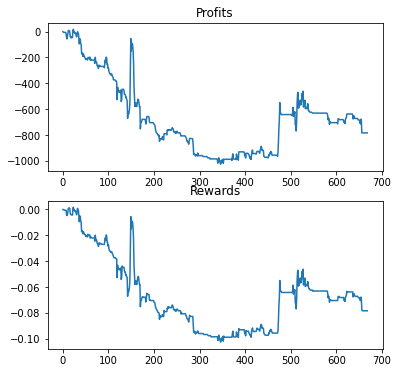

In [8]:
fig, ax = plt.subplots(2,1, figsize=(6,6))
ax[0].plot(df.profit)
ax[0].set_title("Profits")
y = [ast.literal_eval(x)[0] for x  in df.reward]
ax[1].plot(y)
ax[1].set_title("Rewards")
plt.show()

# Param combination 1

In [ ]:
i = 1
train_folder = conduct_traning(hpo_list[i], i)

In [ ]:
# Plot profit
training_folders.append(train_folder)
df = pd.read_csv(f'{train_folder}/Trainer_Data.csv')
print(df.shape)
print(max(df.time_elapsed))

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(6,6))
ax[0].plot(df.profit)
ax[0].set_title("Profits")
y = [ast.literal_eval(x)[0] for x  in df.reward]
ax[1].plot(y)
ax[1].set_title("Rewards")
plt.show()

# param combination 2

In [ ]:
i = 2
train_folder = conduct_traning(hpo_list[i], i)

In [ ]:
# Plot profit
training_folders.append(train_folder)
df = pd.read_csv(f'{train_folder}/Trainer_Data.csv')
print(df.shape)
print(max(df.time_elapsed))

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(6,6))
ax[0].plot(df.profit)
ax[0].set_title("Profits")
y = [ast.literal_eval(x)[0] for x  in df.reward]
ax[1].plot(y)
ax[1].set_title("Rewards")
plt.show()

# Param combination 3

In [ ]:
i = 3
train_folder = conduct_traning(hpo_list[i], i)

In [ ]:
# Plot profit
training_folders.append(train_folder)
df = pd.read_csv(f'{train_folder}/Trainer_Data.csv')
print(df.shape)
print(max(df.time_elapsed))

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(6,6))
ax[0].plot(df.profit)
ax[0].set_title("Profits")
y = [ast.literal_eval(x)[0] for x  in df.reward]
ax[1].plot(y)
ax[1].set_title("Rewards")
plt.show()

# Param combination 4

In [ ]:
i = 4
train_folder = conduct_traning(hpo_list[i], i)

In [ ]:
# Plot profit
training_folders.append(train_folder)
df = pd.read_csv(f'{train_folder}/Trainer_Data.csv')
print(df.shape)
print(max(df.time_elapsed))

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(6,6))
ax[0].plot(df.profit)
ax[0].set_title("Profits")
y = [ast.literal_eval(x)[0] for x  in df.reward]
ax[1].plot(y)
ax[1].set_title("Rewards")
plt.show()

# Param combination 5

In [ ]:
i = 5
train_folder = conduct_traning(hpo_list[i], i)

In [ ]:
# Plot profit
training_folders.append(train_folder)
df = pd.read_csv(f'{train_folder}/Trainer_Data.csv')
print(df.shape)
print(max(df.time_elapsed))

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(6,6))
ax[0].plot(df.profit)
ax[0].set_title("Profits")
y = [ast.literal_eval(x)[0] for x  in df.reward]
ax[1].plot(y)
ax[1].set_title("Rewards")
plt.show()

# Param combination 6

In [ ]:
i = 6
train_folder = conduct_traning(hpo_list[i], i)

In [ ]:
# Plot profit
training_folders.append(train_folder)
df = pd.read_csv(f'{train_folder}/Trainer_Data.csv')
print(df.shape)
print(max(df.time_elapsed))

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(6,6))
ax[0].plot(df.profit)
ax[0].set_title("Profits")
y = [ast.literal_eval(x)[0] for x  in df.reward]
ax[1].plot(y)
ax[1].set_title("Rewards")
plt.show()

# Param combination 7

In [ ]:
i = 7
train_folder = conduct_traning(hpo_list[i], i)

In [ ]:
# Plot profit
training_folders.append(train_folder)
df = pd.read_csv(f'{train_folder}/Trainer_Data.csv')
print(df.shape)
print(max(df.time_elapsed))

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(6,6))
ax[0].plot(df.profit)
ax[0].set_title("Profits")
y = [ast.literal_eval(x)[0] for x  in df.reward]
ax[1].plot(y)
ax[1].set_title("Rewards")
plt.show()